## The University of Melbourne, School of Computing and Information Systems
# COMP90049 Introduction to Machine Learning, 2020 Semester 2
-----
## Project 2: Music Genre Prediction from Audio, Metadata and Text Features!
-----
###### Student Name(s): Ziqi Jia, 693241
###### Python version: 3.7.1
###### Submission deadline: October 16 5PM

In [1]:
#import library
import pandas as pd 
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,classification_report
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_learning_curves

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#read the data from csv
train_fea=pd.read_csv("train_features.csv")
train_lable=pd.read_csv("train_labels.csv")
train_data=train_fea.merge(train_lable,on='trackID',how='left')

In [3]:
valid_fea=pd.read_csv("valid_features.csv")
valid_lable=pd.read_csv("valid_labels.csv")
valid_data=valid_fea.merge(valid_lable,on='trackID',how='left')

In [4]:
train_data.columns

Index(['trackID', 'title', 'tags', 'loudness', 'tempo', 'time_signature',
       'key', 'mode', 'duration', 'vect_1',
       ...
       'vect_140', 'vect_141', 'vect_142', 'vect_143', 'vect_144', 'vect_145',
       'vect_146', 'vect_147', 'vect_148', 'genre'],
      dtype='object', length=158)

In [5]:
#delete the unused column
del train_data['trackID']
del valid_data['trackID']

In [6]:
test_data=pd.read_csv("test_features.csv")
test_Id=test_data['trackID']
del test_data['trackID']

In [7]:
train_data.describe()

,loudness,tempo,time_signature,key,mode,duration,vect_1,vect_2,vect_3,vect_4,...,vect_139,vect_140,vect_141,vect_142,vect_143,vect_144,vect_145,vect_146,vect_147,vect_148
count,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,...,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000
mean,-9.494153,126.009792,3.569549,5.219588,0.684032,239.393681,43.720532,4.292977,8.588045,-2.481427,...,0.000720,0.000769,0.000795,0.000820,0.000816,0.000785,0.000750,0.000700,0.193354,5.187605
std,4.409380,34.700382,1.197146,3.584950,0.464930,88.222516,5.668397,48.672345,29.727550,13.769375,...,0.000658,0.000693,0.000720,0.000729,0.000724,0.000717,0.000692,0.000654,0.085880,42.563533
min,-35.726000,0.000000,0.000000,0.000000,0.000000,5.276280,17.606993,-289.862566,-140.558193,-57.056747,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-12.169000,99.998500,3.000000,2.000000,0.000000,187.663220,40.119825,-25.629972,-8.826299,-10.718885,...,0.000279,0.000298,0.000305,0.000319,0.000317,0.000299,0.000292,0.000274,0.129476,0.720568
50%,-8.666500,121.930500,4.000000,5.000000,1.000000,229.302405,44.266195,8.946854,10.130017,-3.262164,...,0.000560,0.000595,0.000611,0.000636,0.000634,0.000601,0.000570,0.000531,0.179333,1.574559
75%,-6.101250,147.055750,4.000000,9.000000,1.000000,276.329340,48.046192,38.599241,27.192269,4.784411,...,0.000917,0.000988,0.001025,0.001056,0.001056,0.001004,0.000951,0.000878,0.244223,3.695307
max,-0.414000,253.036000,7.000000,11.000000,1.000000,1271.718730,55.564543,133.681468,157.483210,92.816493,...,0.006545,0.006613,0.006698,0.006682,0.006645,0.006777,0.006770,0.006632,0.767182,3193.622527


In [8]:
train_data['genre'].unique()

array(['metal', 'folk', 'jazz and blues', 'soul and reggae',
       'classic pop and rock', 'punk', 'dance and electronica', 'pop'],
      dtype=object)

In [9]:
label_reflect={'metal':0,'folk':1,'jazz and blues':2,'soul and reggae':3,'classic pop and rock':4,'punk':5,'dance and electronica':6,'pop':7} 

In [10]:
label_back={0:'metal',1:'folk',2:'jazz and blues',3:'soul and reggae',4:'classic pop and rock',5:'punk',6:'dance and electronica',7:'pop'} 

In [11]:
train_data['genre']=train_data['genre'].map(label_reflect)

In [12]:
valid_data['genre']=valid_data['genre'].map(label_reflect)

In [13]:
# use TfidfVectorizer to handle text features
tfidf_model_title = TfidfVectorizer(stop_words='english').fit(train_data['title'])
train_title_sparse_result = tfidf_model_title.transform(train_data['title']).todense()
valid_title_sparse_result = tfidf_model_title.transform(valid_data['title']).todense()
test_title_sparse_result = tfidf_model_title.transform(test_data['title']).todense()

In [14]:
tfidf_model_tags = TfidfVectorizer(stop_words='english').fit(train_data['tags'])
train_tags_sparse_result = tfidf_model_tags.transform(train_data['tags']).todense()
valid_tags_sparse_result = tfidf_model_tags.transform(valid_data['tags']).todense()
test_tags_sparse_result = tfidf_model_tags.transform(test_data['tags']).todense()

In [15]:
# use pca to reduce the dimension of trait matrix
pca = PCA(n_components=10)
train_title_sparse_result_pca=pca.fit_transform(train_title_sparse_result)
valid_title_sparse_result_pca=pca.transform(valid_title_sparse_result)
test_title_sparse_result_pca=pca.transform(test_title_sparse_result)

In [16]:
pca2 = PCA(n_components=10)
train_tags_sparse_result_pca=pca2.fit_transform(train_tags_sparse_result)
valid_tags_sparse_result_pca=pca2.transform(valid_tags_sparse_result)
test_tags_sparse_result_pca=pca2.transform(test_tags_sparse_result)

In [17]:
for data in [train_data,valid_data,test_data]:
    del data['title']
    del data['tags']

train_label=train_data['genre']
valid_label=valid_data['genre']

del valid_data['genre']
del train_data['genre']

In [18]:
# cancat all the features together
train_new_fea=pd.concat([ train_data,pd.DataFrame(train_tags_sparse_result_pca),pd.DataFrame(train_title_sparse_result_pca)], axis=1)
valid_new_fea=pd.concat([ valid_data,pd.DataFrame(valid_tags_sparse_result_pca),pd.DataFrame(valid_title_sparse_result_pca)], axis=1)
test_new_fea=pd.concat([ test_data,pd.DataFrame(test_tags_sparse_result_pca),pd.DataFrame(test_title_sparse_result_pca)], axis=1)

In [19]:
# model predict
from sklearn.preprocessing import StandardScaler
sca=StandardScaler()
train_new_fea_std=sca.fit_transform(train_new_fea)
valid_new_fea_std=sca.transform(valid_new_fea)
test_new_fea_std=sca.transform(test_new_fea)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  



##### SVM model

In [20]:
# SVM model
clf = SVC(decision_function_shape='ovo')
clf.fit(train_new_fea_std,train_label)
pre_valid_label_svc=clf.predict(valid_new_fea_std)
print("the acc of svm is:")
accuracy_score(pre_valid_label_svc,valid_label)

the acc of svm is:


0.6755555555555556

In [21]:
# classification report
print(clf)
print(classification_report(pre_valid_label_svc,valid_label))
print("Note: 0:'metal',1:'folk',2:'jazz and blues',3:'soul and reggae',4:'classic pop and rock',5:'punk',6:'dance and electronica',7:'pop'")

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
              precision    recall  f1-score   support

           0       0.64      0.91      0.75        46
           1       0.69      0.45      0.55        97
           2       0.30      0.93      0.45        14
           3       0.81      0.85      0.83        55
           4       0.75      0.47      0.58        87
           5       0.80      0.58      0.67        60
           6       0.31      0.74      0.44        19
           7       0.92      0.94      0.93        72

   micro avg       0.68      0.68      0.68       450
   macro avg       0.65      0.74      0.65       450
weighted avg       0.73      0.68      0.68       450

Note: 0:'metal',1:'folk',2:'jazz and blues',3:'soul and reggae',4:'classic pop and rock',5:'punk',6:'dance and el

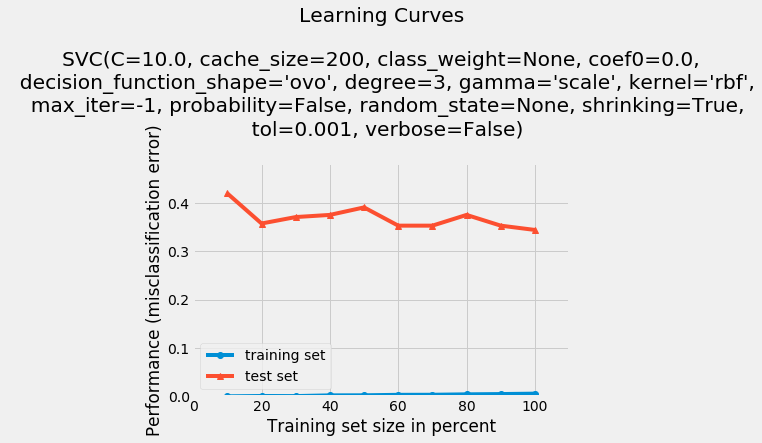

In [22]:
# learning curve of SVM model
clf = SVC(C = 10.0, kernel = 'rbf', gamma = 'scale', decision_function_shape='ovo')
plot_learning_curves(train_new_fea_std, train_label, valid_new_fea_std, valid_label, clf)
plt.show()

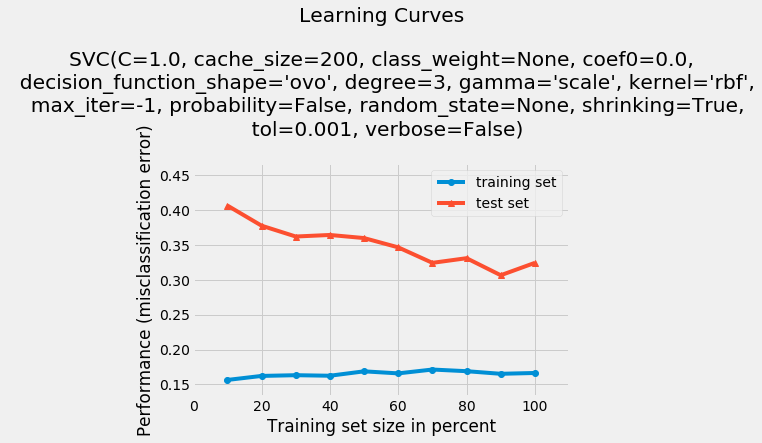

In [23]:
# learning curve of re-tuned SVM model
clf = SVC(C = 1.0, kernel = 'rbf', gamma = 'scale', decision_function_shape='ovo')
plot_learning_curves(train_new_fea_std, train_label, valid_new_fea_std, valid_label, clf)
plt.show()

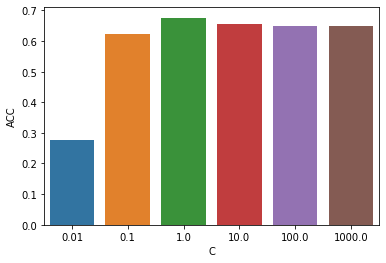

In [24]:
# SVM Accuracy vs C parameter.
acc_C=[]
for c in [0.01,0.1,1,10,100,1000]:
    clf = SVC(decision_function_shape='ovo',C=c)
    clf.fit(train_new_fea_std,train_label)
    pre_valid_label=clf.predict(valid_new_fea_std)
    acc_C.append(accuracy_score(pre_valid_label,valid_label))
data=pd.DataFrame()
data['C']=list([0.01,0.1,1,10,100,1000])
data['ACC']=list(acc_C)
sns.barplot(x="C", y="ACC", data=data)

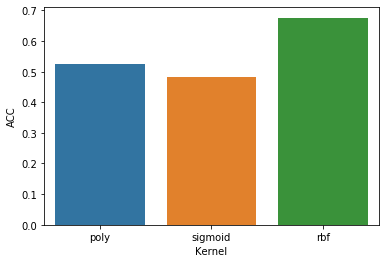

In [25]:
# SVM Accuracy vs Kernel type.
acc_Kernel=[]
for c in ['poly','sigmoid','rbf']:
    clf = SVC(decision_function_shape='ovo',kernel=c)
    clf.fit(train_new_fea_std,train_label)
    pre_valid_label=clf.predict(valid_new_fea_std)
    acc_Kernel.append(accuracy_score(pre_valid_label,valid_label))
data=pd.DataFrame()
data['Kernel']=list(['poly','sigmoid','rbf'])
data['ACC']=list(acc_Kernel)
sns.barplot(x="Kernel", y="ACC", data=data)

In [26]:
# prediction
test_pre_label=clf.predict(test_new_fea_std)

In [27]:
# export testing result
res=pd.DataFrame()
res['trackID']=test_Id
res['genre']=test_pre_label
res['genre']=res['genre'].map(label_back)
res.to_csv('svm.csv',index=False)

##### MLP model

In [28]:
#MLP model
mlp = MLPClassifier(solver='sgd', activation='relu',alpha=1e-4,hidden_layer_sizes=(50,50), random_state=1,max_iter=10,verbose=10,learning_rate_init=.1)
mlp.fit(train_new_fea_std,train_label)
pre_valid_label=mlp.predict(valid_new_fea_std)
accuracy_score(pre_valid_label,valid_label)
test_pre_label=mlp.predict(test_new_fea_std)
print("the acc of mlp is:")
accuracy_score(pre_valid_label,valid_label)

Iteration 1, loss = 1.37159681
Iteration 2, loss = 0.95730236
Iteration 3, loss = 0.85129902
Iteration 4, loss = 0.77573314
Iteration 5, loss = 0.71091231
Iteration 6, loss = 0.64895653
Iteration 7, loss = 0.61074985
Iteration 8, loss = 0.56274799
Iteration 9, loss = 0.52981247
Iteration 10, loss = 0.50872545
the acc of mlp is:


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.5955555555555555

In [29]:
# classification report
print(mlp)
print(classification_report(pre_valid_label,valid_label))
print("Note: 0:'metal',1:'folk',2:'jazz and blues',3:'soul and reggae',4:'classic pop and rock',5:'punk',6:'dance and electronica',7:'pop'")

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50), learning_rate='constant',
       learning_rate_init=0.1, max_iter=10, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=10, warm_start=False)
              precision    recall  f1-score   support

           0       0.83      0.90      0.87        61
           1       0.70      0.48      0.57        93
           2       0.25      0.69      0.37        16
           3       0.57      0.55      0.56        60
           4       0.44      0.39      0.41        61
           5       0.64      0.47      0.54        59
           6       0.44      0.54      0.49        37
           7       0.70      0.83      0.76        63

   micro avg       0.60      0.60      0.60       450
   macro av

Iteration 1, loss = 8.10389335
Iteration 2, loss = 5.35417728
Iteration 3, loss = 1.78555652
Iteration 4, loss = 1.70325599
Iteration 5, loss = 1.65442367
Iteration 6, loss = 1.59257638
Iteration 7, loss = 1.49786556
Iteration 8, loss = 1.43278801
Iteration 9, loss = 1.40980973
Iteration 10, loss = 1.40731863
Iteration 1, loss = 6.47703247
Iteration 2, loss = 1.99123042
Iteration 3, loss = 1.96824613
Iteration 4, loss = 1.93836157
Iteration 5, loss = 1.93149180
Iteration 6, loss = 1.93621937
Iteration 7, loss = 1.92379982
Iteration 8, loss = 1.92870903


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 9, loss = 1.93379171
Iteration 10, loss = 1.93965663
Iteration 1, loss = 6.22799898
Iteration 2, loss = 2.02893070
Iteration 3, loss = 1.95447756
Iteration 4, loss = 1.94446585
Iteration 5, loss = 1.92618664
Iteration 6, loss = 1.90373699
Iteration 7, loss = 1.87834837
Iteration 8, loss = 1.82252979
Iteration 9, loss = 1.80588065
Iteration 10, loss = 1.78721952
Iteration 1, loss = 4.45107011


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 1.99313611
Iteration 3, loss = 1.96594320
Iteration 4, loss = 1.96482321
Iteration 5, loss = 1.96430446
Iteration 6, loss = 1.96312492
Iteration 7, loss = 1.96471104
Iteration 8, loss = 1.96421519
Iteration 9, loss = 1.95985273
Iteration 10, loss = 1.95549298
Iteration 1, loss = 3.97157649
Iteration 2, loss = 1.96674456
Iteration 3, loss = 1.96142508


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 4, loss = 1.96003227
Iteration 5, loss = 1.96084117
Iteration 6, loss = 1.96140764
Iteration 7, loss = 1.96343859
Iteration 8, loss = 1.96196740
Iteration 9, loss = 1.96154266
Iteration 10, loss = 1.96147852
Iteration 1, loss = 3.40654752
Iteration 2, loss = 1.89104218
Iteration 3, loss = 1.80913110


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 4, loss = 1.78543813
Iteration 5, loss = 1.79331132
Iteration 6, loss = 1.71227746
Iteration 7, loss = 1.67413784
Iteration 8, loss = 1.64981335
Iteration 9, loss = 1.61023644
Iteration 10, loss = 1.57246753
Iteration 1, loss = 3.19382108
Iteration 2, loss = 1.65171060
Iteration 3, loss = 1.60161251
Iteration 4, loss = 1.54592033


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 5, loss = 1.53003034
Iteration 6, loss = 1.50796522
Iteration 7, loss = 1.48354611
Iteration 8, loss = 1.43497659
Iteration 9, loss = 1.45847446
Iteration 10, loss = 1.44967813
Iteration 1, loss = 3.15960475
Iteration 2, loss = 1.86647878
Iteration 3, loss = 1.77609797


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 4, loss = 1.76887532
Iteration 5, loss = 1.74627672
Iteration 6, loss = 1.71354191
Iteration 7, loss = 1.67735866
Iteration 8, loss = 1.69810307
Iteration 9, loss = 1.67018337
Iteration 10, loss = 1.65749569
Iteration 1, loss = 2.87127062
Iteration 2, loss = 1.59291992


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 3, loss = 1.49756479
Iteration 4, loss = 1.47378471
Iteration 5, loss = 1.44557375
Iteration 6, loss = 1.39741174
Iteration 7, loss = 1.37591311
Iteration 8, loss = 1.40348123
Iteration 9, loss = 1.34875894
Iteration 10, loss = 1.33553356
Iteration 1, loss = 2.64143765


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 1.60889419
Iteration 3, loss = 1.56548022
Iteration 4, loss = 1.53440885
Iteration 5, loss = 1.49827360
Iteration 6, loss = 1.48320866
Iteration 7, loss = 1.43352679
Iteration 8, loss = 1.41750782
Iteration 9, loss = 1.42314926
Iteration 10, loss = 1.41759223


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


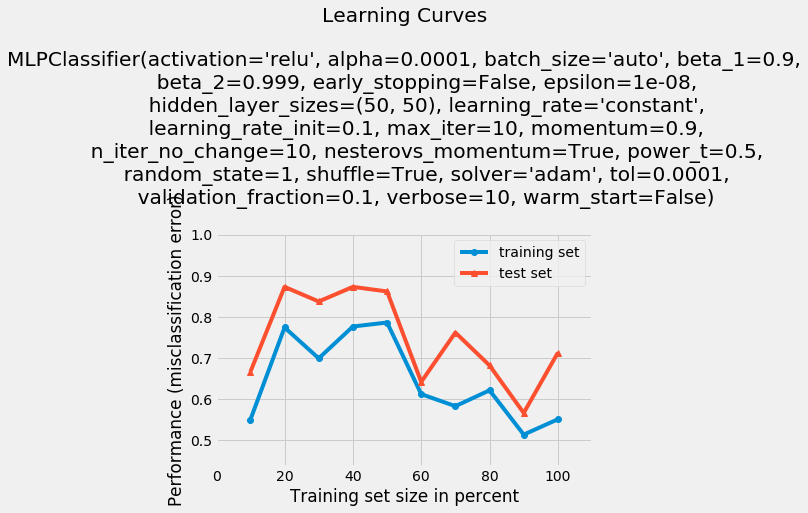

In [30]:
# learning curve of MLP model
mlp = MLPClassifier(solver='adam', activation='relu',alpha=1e-4,hidden_layer_sizes=(50,50), random_state=1,max_iter=10,verbose=10,learning_rate_init=.1)
plot_learning_curves(train_new_fea_std, train_label, valid_new_fea_std, valid_label, mlp)
plt.show()

Iteration 1, loss = 2.15863726
Iteration 2, loss = 1.58037881
Iteration 3, loss = 1.34202718
Iteration 4, loss = 1.14165744
Iteration 5, loss = 1.04098171
Iteration 6, loss = 0.81089008
Iteration 7, loss = 0.66079130
Iteration 8, loss = 0.55623337
Iteration 9, loss = 0.43271678
Iteration 10, loss = 0.37470455
Iteration 1, loss = 1.91984818
Iteration 2, loss = 1.33382488
Iteration 3, loss = 1.07229320
Iteration 4, loss = 0.94304497
Iteration 5, loss = 0.76845582
Iteration 6, loss = 0.66201529
Iteration 7, loss = 0.56164006
Iteration 8, loss = 0.48623094
Iteration 9, loss = 0.40194607
Iteration 10, loss = 0.33128449
Iteration 1, loss = 1.78517270


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 1.22873972
Iteration 3, loss = 0.97138668
Iteration 4, loss = 0.83318451
Iteration 5, loss = 0.73377074
Iteration 6, loss = 0.63795066
Iteration 7, loss = 0.54992593
Iteration 8, loss = 0.48558597
Iteration 9, loss = 0.41944365
Iteration 10, loss = 0.38605064
Iteration 1, loss = 1.67377438


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 1.11516117
Iteration 3, loss = 0.92052112
Iteration 4, loss = 0.79228463
Iteration 5, loss = 0.71000133
Iteration 6, loss = 0.63552197
Iteration 7, loss = 0.57538471
Iteration 8, loss = 0.52190689
Iteration 9, loss = 0.45817363
Iteration 10, loss = 0.41555247


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 1.59598930
Iteration 2, loss = 1.08648186
Iteration 3, loss = 0.93673603
Iteration 4, loss = 0.82235959
Iteration 5, loss = 0.72791692
Iteration 6, loss = 0.66809531
Iteration 7, loss = 0.59221255
Iteration 8, loss = 0.61096635
Iteration 9, loss = 0.54098101
Iteration 10, loss = 0.51134862
Iteration 1, loss = 1.54589329
Iteration 2, loss = 1.09291617


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 3, loss = 0.98528421
Iteration 4, loss = 0.91202328
Iteration 5, loss = 0.86391811
Iteration 6, loss = 0.75964625
Iteration 7, loss = 0.74963509
Iteration 8, loss = 0.71563243
Iteration 9, loss = 0.64874155
Iteration 10, loss = 0.62111037
Iteration 1, loss = 1.49028269
Iteration 2, loss = 1.00680064
Iteration 3, loss = 0.87522287
Iteration 4, loss = 0.77522582


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 5, loss = 0.70166232
Iteration 6, loss = 0.63747890
Iteration 7, loss = 0.58776745
Iteration 8, loss = 0.55656981
Iteration 9, loss = 0.50809178
Iteration 10, loss = 0.44775220


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 1.44768876
Iteration 2, loss = 0.98764988
Iteration 3, loss = 0.85970964
Iteration 4, loss = 0.77153732
Iteration 5, loss = 0.70607863
Iteration 6, loss = 0.64392263
Iteration 7, loss = 0.60398908
Iteration 8, loss = 0.55500205
Iteration 9, loss = 0.50731911
Iteration 10, loss = 0.46436323


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 1.40188020
Iteration 2, loss = 0.96592006
Iteration 3, loss = 0.83730071
Iteration 4, loss = 0.75597959
Iteration 5, loss = 0.69199639
Iteration 6, loss = 0.64521161
Iteration 7, loss = 0.60432952
Iteration 8, loss = 0.55759250
Iteration 9, loss = 0.50669857
Iteration 10, loss = 0.48767954
Iteration 1, loss = 1.37159681
Iteration 2, loss = 0.95730236
Iteration 3, loss = 0.85129902


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 4, loss = 0.77573314
Iteration 5, loss = 0.71091231
Iteration 6, loss = 0.64895653
Iteration 7, loss = 0.61074985
Iteration 8, loss = 0.56274799
Iteration 9, loss = 0.52981247
Iteration 10, loss = 0.50872545


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


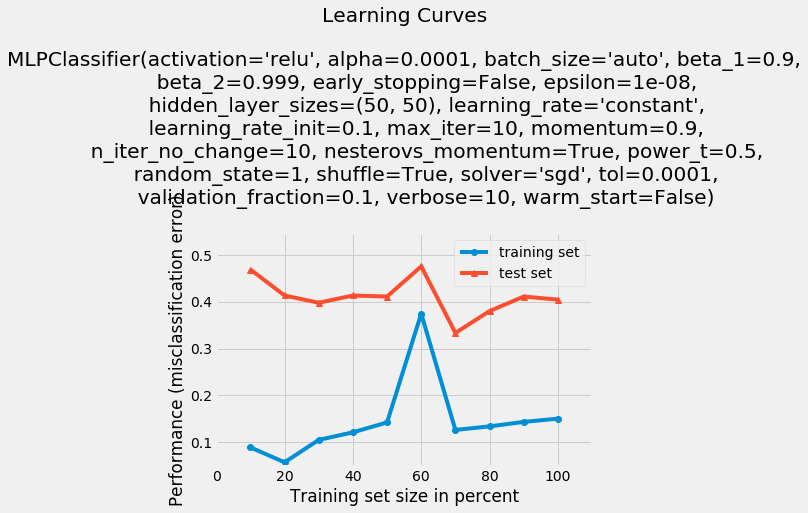

In [31]:
# learning curve of re-tuned MLP model
mlp = MLPClassifier(solver='sgd', activation='relu',alpha=1e-4,hidden_layer_sizes=(50,50), random_state=1,max_iter=10,verbose=10,learning_rate_init=.1)
plot_learning_curves(train_new_fea_std, train_label, valid_new_fea_std, valid_label, mlp)
plt.show()

In [32]:
train_acc=[]
test_acc=[]
for epochs in range(10,50,3):
    mlp = MLPClassifier(solver='sgd', activation='relu',alpha=1e-4,hidden_layer_sizes=(50,50), random_state=1,max_iter=epochs,verbose=10,learning_rate_init=.1)
    mlp.fit(train_new_fea_std,train_label)
    pre_valid_label=mlp.predict(valid_new_fea_std)
    pre_train_label=mlp.predict(train_new_fea_std)
    train_acc.append(accuracy_score(pre_train_label,train_label))
    test_acc.append(accuracy_score(pre_valid_label,valid_label))


Iteration 1, loss = 1.37159681
Iteration 2, loss = 0.95730236
Iteration 3, loss = 0.85129902
Iteration 4, loss = 0.77573314
Iteration 5, loss = 0.71091231
Iteration 6, loss = 0.64895653
Iteration 7, loss = 0.61074985
Iteration 8, loss = 0.56274799
Iteration 9, loss = 0.52981247
Iteration 10, loss = 0.50872545
Iteration 1, loss = 1.37159681


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 0.95730236
Iteration 3, loss = 0.85129902
Iteration 4, loss = 0.77573314
Iteration 5, loss = 0.71091231
Iteration 6, loss = 0.64895653
Iteration 7, loss = 0.61074985
Iteration 8, loss = 0.56274799
Iteration 9, loss = 0.52981247
Iteration 10, loss = 0.50872545
Iteration 11, loss = 0.49120087
Iteration 12, loss = 0.44692451
Iteration 13, loss = 0.42292714
Iteration 1, loss = 1.37159681
Iteration 2, loss = 0.95730236
Iteration 3, loss = 0.85129902


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 4, loss = 0.77573314
Iteration 5, loss = 0.71091231
Iteration 6, loss = 0.64895653
Iteration 7, loss = 0.61074985
Iteration 8, loss = 0.56274799
Iteration 9, loss = 0.52981247
Iteration 10, loss = 0.50872545
Iteration 11, loss = 0.49120087
Iteration 12, loss = 0.44692451
Iteration 13, loss = 0.42292714
Iteration 14, loss = 0.40640168
Iteration 15, loss = 0.40279781
Iteration 16, loss = 0.35784473
Iteration 1, loss = 1.37159681


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 0.95730236
Iteration 3, loss = 0.85129902
Iteration 4, loss = 0.77573314
Iteration 5, loss = 0.71091231
Iteration 6, loss = 0.64895653
Iteration 7, loss = 0.61074985
Iteration 8, loss = 0.56274799
Iteration 9, loss = 0.52981247
Iteration 10, loss = 0.50872545
Iteration 11, loss = 0.49120087
Iteration 12, loss = 0.44692451
Iteration 13, loss = 0.42292714
Iteration 14, loss = 0.40640168
Iteration 15, loss = 0.40279781
Iteration 16, loss = 0.35784473
Iteration 17, loss = 0.35449859
Iteration 18, loss = 0.34428453
Iteration 19, loss = 0.32033783


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 1.37159681
Iteration 2, loss = 0.95730236
Iteration 3, loss = 0.85129902
Iteration 4, loss = 0.77573314
Iteration 5, loss = 0.71091231
Iteration 6, loss = 0.64895653
Iteration 7, loss = 0.61074985
Iteration 8, loss = 0.56274799
Iteration 9, loss = 0.52981247
Iteration 10, loss = 0.50872545
Iteration 11, loss = 0.49120087
Iteration 12, loss = 0.44692451
Iteration 13, loss = 0.42292714
Iteration 14, loss = 0.40640168
Iteration 15, loss = 0.40279781
Iteration 16, loss = 0.35784473
Iteration 17, loss = 0.35449859
Iteration 18, loss = 0.34428453
Iteration 19, loss = 0.32033783
Iteration 20, loss = 0.31749976
Iteration 21, loss = 0.29718991
Iteration 22, loss = 0.29976781


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 1.37159681
Iteration 2, loss = 0.95730236
Iteration 3, loss = 0.85129902
Iteration 4, loss = 0.77573314
Iteration 5, loss = 0.71091231
Iteration 6, loss = 0.64895653
Iteration 7, loss = 0.61074985
Iteration 8, loss = 0.56274799
Iteration 9, loss = 0.52981247
Iteration 10, loss = 0.50872545
Iteration 11, loss = 0.49120087
Iteration 12, loss = 0.44692451
Iteration 13, loss = 0.42292714
Iteration 14, loss = 0.40640168
Iteration 15, loss = 0.40279781
Iteration 16, loss = 0.35784473
Iteration 17, loss = 0.35449859
Iteration 18, loss = 0.34428453
Iteration 19, loss = 0.32033783
Iteration 20, loss = 0.31749976
Iteration 21, loss = 0.29718991
Iteration 22, loss = 0.29976781
Iteration 23, loss = 0.28444827
Iteration 24, loss = 0.30153862
Iteration 25, loss = 0.28162190


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 1.37159681
Iteration 2, loss = 0.95730236
Iteration 3, loss = 0.85129902
Iteration 4, loss = 0.77573314
Iteration 5, loss = 0.71091231
Iteration 6, loss = 0.64895653
Iteration 7, loss = 0.61074985
Iteration 8, loss = 0.56274799
Iteration 9, loss = 0.52981247
Iteration 10, loss = 0.50872545
Iteration 11, loss = 0.49120087
Iteration 12, loss = 0.44692451
Iteration 13, loss = 0.42292714
Iteration 14, loss = 0.40640168
Iteration 15, loss = 0.40279781
Iteration 16, loss = 0.35784473
Iteration 17, loss = 0.35449859
Iteration 18, loss = 0.34428453
Iteration 19, loss = 0.32033783
Iteration 20, loss = 0.31749976
Iteration 21, loss = 0.29718991
Iteration 22, loss = 0.29976781
Iteration 23, loss = 0.28444827
Iteration 24, loss = 0.30153862
Iteration 25, loss = 0.28162190
Iteration 26, loss = 0.23827981
Iteration 27, loss = 0.23482454
Iteration 28, loss = 0.24330758


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 1.37159681
Iteration 2, loss = 0.95730236
Iteration 3, loss = 0.85129902
Iteration 4, loss = 0.77573314
Iteration 5, loss = 0.71091231
Iteration 6, loss = 0.64895653
Iteration 7, loss = 0.61074985
Iteration 8, loss = 0.56274799
Iteration 9, loss = 0.52981247
Iteration 10, loss = 0.50872545
Iteration 11, loss = 0.49120087
Iteration 12, loss = 0.44692451
Iteration 13, loss = 0.42292714
Iteration 14, loss = 0.40640168
Iteration 15, loss = 0.40279781
Iteration 16, loss = 0.35784473
Iteration 17, loss = 0.35449859
Iteration 18, loss = 0.34428453
Iteration 19, loss = 0.32033783
Iteration 20, loss = 0.31749976
Iteration 21, loss = 0.29718991
Iteration 22, loss = 0.29976781
Iteration 23, loss = 0.28444827
Iteration 24, loss = 0.30153862
Iteration 25, loss = 0.28162190
Iteration 26, loss = 0.23827981
Iteration 27, loss = 0.23482454
Iteration 28, loss = 0.24330758
Iteration 29, loss = 0.24806271
Iteration 30, loss = 0.23816571
Iteration 31, loss = 0.23097107


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 1.37159681
Iteration 2, loss = 0.95730236
Iteration 3, loss = 0.85129902
Iteration 4, loss = 0.77573314
Iteration 5, loss = 0.71091231
Iteration 6, loss = 0.64895653
Iteration 7, loss = 0.61074985
Iteration 8, loss = 0.56274799
Iteration 9, loss = 0.52981247
Iteration 10, loss = 0.50872545
Iteration 11, loss = 0.49120087
Iteration 12, loss = 0.44692451
Iteration 13, loss = 0.42292714
Iteration 14, loss = 0.40640168
Iteration 15, loss = 0.40279781
Iteration 16, loss = 0.35784473
Iteration 17, loss = 0.35449859
Iteration 18, loss = 0.34428453
Iteration 19, loss = 0.32033783
Iteration 20, loss = 0.31749976
Iteration 21, loss = 0.29718991
Iteration 22, loss = 0.29976781
Iteration 23, loss = 0.28444827
Iteration 24, loss = 0.30153862
Iteration 25, loss = 0.28162190
Iteration 26, loss = 0.23827981
Iteration 27, loss = 0.23482454
Iteration 28, loss = 0.24330758
Iteration 29, loss = 0.24806271
Iteration 30, loss = 0.23816571
Iteration 31, loss = 0.23097107
Iteration 32, los

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 3, loss = 0.85129902
Iteration 4, loss = 0.77573314
Iteration 5, loss = 0.71091231
Iteration 6, loss = 0.64895653
Iteration 7, loss = 0.61074985
Iteration 8, loss = 0.56274799
Iteration 9, loss = 0.52981247
Iteration 10, loss = 0.50872545
Iteration 11, loss = 0.49120087
Iteration 12, loss = 0.44692451
Iteration 13, loss = 0.42292714
Iteration 14, loss = 0.40640168
Iteration 15, loss = 0.40279781
Iteration 16, loss = 0.35784473
Iteration 17, loss = 0.35449859
Iteration 18, loss = 0.34428453
Iteration 19, loss = 0.32033783
Iteration 20, loss = 0.31749976
Iteration 21, loss = 0.29718991
Iteration 22, loss = 0.29976781
Iteration 23, loss = 0.28444827
Iteration 24, loss = 0.30153862
Iteration 25, loss = 0.28162190
Iteration 26, loss = 0.23827981
Iteration 27, loss = 0.23482454
Iteration 28, loss = 0.24330758
Iteration 29, loss = 0.24806271
Iteration 30, loss = 0.23816571
Iteration 31, loss = 0.23097107
Iteration 32, loss = 0.24053744
Iteration 33, loss = 0.22994562
Iteration 34, l

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 0.95730236
Iteration 3, loss = 0.85129902
Iteration 4, loss = 0.77573314
Iteration 5, loss = 0.71091231
Iteration 6, loss = 0.64895653
Iteration 7, loss = 0.61074985
Iteration 8, loss = 0.56274799
Iteration 9, loss = 0.52981247
Iteration 10, loss = 0.50872545
Iteration 11, loss = 0.49120087
Iteration 12, loss = 0.44692451
Iteration 13, loss = 0.42292714
Iteration 14, loss = 0.40640168
Iteration 15, loss = 0.40279781
Iteration 16, loss = 0.35784473
Iteration 17, loss = 0.35449859
Iteration 18, loss = 0.34428453
Iteration 19, loss = 0.32033783
Iteration 20, loss = 0.31749976
Iteration 21, loss = 0.29718991
Iteration 22, loss = 0.29976781
Iteration 23, loss = 0.28444827
Iteration 24, loss = 0.30153862
Iteration 25, loss = 0.28162190
Iteration 26, loss = 0.23827981
Iteration 27, loss = 0.23482454
Iteration 28, loss = 0.24330758
Iteration 29, loss = 0.24806271
Iteration 30, loss = 0.23816571
Iteration 31, loss = 0.23097107
Iteration 32, loss = 0.24053744
Iteration 33, lo

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 4, loss = 0.77573314
Iteration 5, loss = 0.71091231
Iteration 6, loss = 0.64895653
Iteration 7, loss = 0.61074985
Iteration 8, loss = 0.56274799
Iteration 9, loss = 0.52981247
Iteration 10, loss = 0.50872545
Iteration 11, loss = 0.49120087
Iteration 12, loss = 0.44692451
Iteration 13, loss = 0.42292714
Iteration 14, loss = 0.40640168
Iteration 15, loss = 0.40279781
Iteration 16, loss = 0.35784473
Iteration 17, loss = 0.35449859
Iteration 18, loss = 0.34428453
Iteration 19, loss = 0.32033783
Iteration 20, loss = 0.31749976
Iteration 21, loss = 0.29718991
Iteration 22, loss = 0.29976781
Iteration 23, loss = 0.28444827
Iteration 24, loss = 0.30153862
Iteration 25, loss = 0.28162190
Iteration 26, loss = 0.23827981
Iteration 27, loss = 0.23482454
Iteration 28, loss = 0.24330758
Iteration 29, loss = 0.24806271
Iteration 30, loss = 0.23816571
Iteration 31, loss = 0.23097107
Iteration 32, loss = 0.24053744
Iteration 33, loss = 0.22994562
Iteration 34, loss = 0.24892242
Iteration 35, 

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (43) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 0.95730236
Iteration 3, loss = 0.85129902
Iteration 4, loss = 0.77573314
Iteration 5, loss = 0.71091231
Iteration 6, loss = 0.64895653
Iteration 7, loss = 0.61074985
Iteration 8, loss = 0.56274799
Iteration 9, loss = 0.52981247
Iteration 10, loss = 0.50872545
Iteration 11, loss = 0.49120087
Iteration 12, loss = 0.44692451
Iteration 13, loss = 0.42292714
Iteration 14, loss = 0.40640168
Iteration 15, loss = 0.40279781
Iteration 16, loss = 0.35784473
Iteration 17, loss = 0.35449859
Iteration 18, loss = 0.34428453
Iteration 19, loss = 0.32033783
Iteration 20, loss = 0.31749976
Iteration 21, loss = 0.29718991
Iteration 22, loss = 0.29976781
Iteration 23, loss = 0.28444827
Iteration 24, loss = 0.30153862
Iteration 25, loss = 0.28162190
Iteration 26, loss = 0.23827981
Iteration 27, loss = 0.23482454
Iteration 28, loss = 0.24330758
Iteration 29, loss = 0.24806271
Iteration 30, loss = 0.23816571
Iteration 31, loss = 0.23097107
Iteration 32, loss = 0.24053744
Iteration 33, lo

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (46) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 0.95730236
Iteration 3, loss = 0.85129902
Iteration 4, loss = 0.77573314
Iteration 5, loss = 0.71091231
Iteration 6, loss = 0.64895653
Iteration 7, loss = 0.61074985
Iteration 8, loss = 0.56274799
Iteration 9, loss = 0.52981247
Iteration 10, loss = 0.50872545
Iteration 11, loss = 0.49120087
Iteration 12, loss = 0.44692451
Iteration 13, loss = 0.42292714
Iteration 14, loss = 0.40640168
Iteration 15, loss = 0.40279781
Iteration 16, loss = 0.35784473
Iteration 17, loss = 0.35449859
Iteration 18, loss = 0.34428453
Iteration 19, loss = 0.32033783
Iteration 20, loss = 0.31749976
Iteration 21, loss = 0.29718991
Iteration 22, loss = 0.29976781
Iteration 23, loss = 0.28444827
Iteration 24, loss = 0.30153862
Iteration 25, loss = 0.28162190
Iteration 26, loss = 0.23827981
Iteration 27, loss = 0.23482454
Iteration 28, loss = 0.24330758
Iteration 29, loss = 0.24806271
Iteration 30, loss = 0.23816571
Iteration 31, loss = 0.23097107
Iteration 32, loss = 0.24053744
Iteration 33, lo

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [33]:
data

,Kernel,ACC
0,poly,0.524444
1,sigmoid,0.482222
2,rbf,0.675556


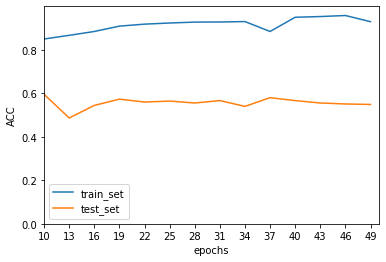

In [34]:
# Acc vs Epochs. SGD solver.
data=pd.DataFrame()
data['train_acc']=train_acc
data['test_acc']=test_acc
plt.xlim((10, 50))
plt.ylim((0, 1))
plt.xlabel('epochs')
plt.ylabel('ACC')
my_x_ticks = np.arange(10, 50, 3)
my_y_ticks = np.arange(0, 1, 0.2)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.plot(list(range(10,50,3)),data['train_acc'],label="train_set")
plt.plot(list(range(10,50,3)),data['test_acc'],label="test_set")
plt.legend()
plt.show()

In [35]:
train_acc=[]
test_acc=[]
for learning_rate in [0.05,0.1,0.2,0.5,1]:
    mlp = MLPClassifier(solver='sgd', activation='relu',alpha=1e-4,hidden_layer_sizes=(50,50), random_state=1,max_iter=epochs,verbose=10,learning_rate_init=learning_rate)
    mlp.fit(train_new_fea_std,train_label)
    pre_valid_label=mlp.predict(valid_new_fea_std)
    pre_train_label=mlp.predict(train_new_fea_std)
    train_acc.append(accuracy_score(pre_train_label,train_label))
    test_acc.append(accuracy_score(pre_valid_label,valid_label))

Iteration 1, loss = 1.46898034
Iteration 2, loss = 1.01276573
Iteration 3, loss = 0.88537734
Iteration 4, loss = 0.81095807
Iteration 5, loss = 0.74753571
Iteration 6, loss = 0.69497941
Iteration 7, loss = 0.64511665
Iteration 8, loss = 0.60955361
Iteration 9, loss = 0.57520712
Iteration 10, loss = 0.54015796
Iteration 11, loss = 0.51132794
Iteration 12, loss = 0.47911244
Iteration 13, loss = 0.45118713
Iteration 14, loss = 0.42913976
Iteration 15, loss = 0.40835780
Iteration 16, loss = 0.38159038
Iteration 17, loss = 0.35467731
Iteration 18, loss = 0.33988963
Iteration 19, loss = 0.32181150
Iteration 20, loss = 0.29240360
Iteration 21, loss = 0.28759819
Iteration 22, loss = 0.29399788
Iteration 23, loss = 0.27982120
Iteration 24, loss = 0.26459719
Iteration 25, loss = 0.26607931
Iteration 26, loss = 0.21154067
Iteration 27, loss = 0.20195695
Iteration 28, loss = 0.20437157
Iteration 29, loss = 0.19550421
Iteration 30, loss = 0.19055169
Iteration 31, loss = 0.16615496
Iteration 32, los

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 3, loss = 0.85129902
Iteration 4, loss = 0.77573314
Iteration 5, loss = 0.71091231
Iteration 6, loss = 0.64895653
Iteration 7, loss = 0.61074985
Iteration 8, loss = 0.56274799
Iteration 9, loss = 0.52981247
Iteration 10, loss = 0.50872545
Iteration 11, loss = 0.49120087
Iteration 12, loss = 0.44692451
Iteration 13, loss = 0.42292714
Iteration 14, loss = 0.40640168
Iteration 15, loss = 0.40279781
Iteration 16, loss = 0.35784473
Iteration 17, loss = 0.35449859
Iteration 18, loss = 0.34428453
Iteration 19, loss = 0.32033783
Iteration 20, loss = 0.31749976
Iteration 21, loss = 0.29718991
Iteration 22, loss = 0.29976781
Iteration 23, loss = 0.28444827
Iteration 24, loss = 0.30153862
Iteration 25, loss = 0.28162190
Iteration 26, loss = 0.23827981
Iteration 27, loss = 0.23482454
Iteration 28, loss = 0.24330758
Iteration 29, loss = 0.24806271
Iteration 30, loss = 0.23816571
Iteration 31, loss = 0.23097107
Iteration 32, loss = 0.24053744
Iteration 33, loss = 0.22994562
Iteration 34, l

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 1.37720542
Iteration 2, loss = 0.99258404
Iteration 3, loss = 0.86858859
Iteration 4, loss = 0.82330047
Iteration 5, loss = 0.75453944
Iteration 6, loss = 0.70061453
Iteration 7, loss = 0.65339652
Iteration 8, loss = 0.65369757
Iteration 9, loss = 0.62048503
Iteration 10, loss = 0.60485187
Iteration 11, loss = 0.57268423
Iteration 12, loss = 0.55837223
Iteration 13, loss = 0.53282784
Iteration 14, loss = 0.52704832
Iteration 15, loss = 0.49874691
Iteration 16, loss = 0.45575948
Iteration 17, loss = 0.44384392
Iteration 18, loss = 0.53073731
Iteration 19, loss = 0.61087944
Iteration 20, loss = 0.51542247
Iteration 21, loss = 0.46647168
Iteration 22, loss = 0.45874179
Iteration 23, loss = 0.50898038
Iteration 24, loss = 0.48433578
Iteration 25, loss = 0.48104733
Iteration 26, loss = 0.45904453
Iteration 27, loss = 0.43399656
Iteration 28, loss = 0.39974374
Iteration 29, loss = 0.40845474
Iteration 30, loss = 0.47808879
Iteration 31, loss = 0.42623476
Iteration 32, los

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 1.96457159
Iteration 2, loss = 1.84706151
Iteration 3, loss = 1.78355224
Iteration 4, loss = 1.76206568
Iteration 5, loss = 1.70393982
Iteration 6, loss = 1.71914952
Iteration 7, loss = 1.80924723
Iteration 8, loss = 1.90505241
Iteration 9, loss = 1.90916751
Iteration 10, loss = 1.89107197
Iteration 11, loss = 1.88937712
Iteration 12, loss = 1.86983221
Iteration 13, loss = 1.86193853
Iteration 14, loss = 1.84603134
Iteration 15, loss = 1.80045660
Iteration 16, loss = 1.79981424
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.45113487
Iteration 2, loss = 1.98410409
Iteration 3, loss = 1.98589402
Iteration 4, loss = 1.98655283
Iteration 5, loss = 1.98612132
Iteration 6, loss = 1.98707098
Iteration 7, loss = 1.98551450
Iteration 8, loss = 1.98638434
Iteration 9, loss = 1.98700014
Iteration 10, loss = 1.98531179
Iteration 11, loss = 1.98609418
Iteration 12, loss = 1.98513666
Iteration 13, loss = 1.98449750


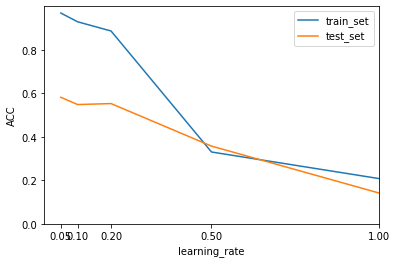

In [36]:
# Acc vs learning rate. SGD solver.
data=pd.DataFrame()
data['train_acc']=train_acc
data['test_acc']=test_acc
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.xlabel('learning_rate')
plt.ylabel('ACC')
my_x_ticks = [0.05,0.1,0.2,0.5,1]
my_y_ticks = np.arange(0, 1, 0.2)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.plot(my_x_ticks,data['train_acc'],label="train_set")
plt.plot(my_x_ticks,data['test_acc'],label="test_set")
plt.legend()
plt.show()

In [37]:
train_acc=[]
test_acc=[]
for epochs in range(10,50,3):
    mlp = MLPClassifier(solver='adam', activation='relu',alpha=1e-4,hidden_layer_sizes=(50,50), random_state=1,max_iter=epochs,verbose=10,learning_rate_init=.1)
    mlp.fit(train_new_fea_std,train_label)
    pre_valid_label=mlp.predict(valid_new_fea_std)
    train_acc.append(accuracy_score(pre_train_label,train_label))
    test_acc.append(accuracy_score(pre_valid_label,valid_label))

Iteration 1, loss = 2.64143765
Iteration 2, loss = 1.60889419
Iteration 3, loss = 1.56548022
Iteration 4, loss = 1.53440885
Iteration 5, loss = 1.49827360
Iteration 6, loss = 1.48320866
Iteration 7, loss = 1.43352679
Iteration 8, loss = 1.41750782
Iteration 9, loss = 1.42314926
Iteration 10, loss = 1.41759223
Iteration 1, loss = 2.64143765


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 1.60889419
Iteration 3, loss = 1.56548022
Iteration 4, loss = 1.53440885
Iteration 5, loss = 1.49827360
Iteration 6, loss = 1.48320866
Iteration 7, loss = 1.43352679
Iteration 8, loss = 1.41750782
Iteration 9, loss = 1.42314926
Iteration 10, loss = 1.41759223
Iteration 11, loss = 1.38136262
Iteration 12, loss = 1.39848989
Iteration 13, loss = 1.37587297


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 2.64143765
Iteration 2, loss = 1.60889419
Iteration 3, loss = 1.56548022
Iteration 4, loss = 1.53440885
Iteration 5, loss = 1.49827360
Iteration 6, loss = 1.48320866
Iteration 7, loss = 1.43352679
Iteration 8, loss = 1.41750782
Iteration 9, loss = 1.42314926
Iteration 10, loss = 1.41759223
Iteration 11, loss = 1.38136262
Iteration 12, loss = 1.39848989
Iteration 13, loss = 1.37587297
Iteration 14, loss = 1.35128311
Iteration 15, loss = 1.32874784
Iteration 16, loss = 1.37801272


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 2.64143765
Iteration 2, loss = 1.60889419
Iteration 3, loss = 1.56548022
Iteration 4, loss = 1.53440885
Iteration 5, loss = 1.49827360
Iteration 6, loss = 1.48320866
Iteration 7, loss = 1.43352679
Iteration 8, loss = 1.41750782
Iteration 9, loss = 1.42314926
Iteration 10, loss = 1.41759223
Iteration 11, loss = 1.38136262
Iteration 12, loss = 1.39848989
Iteration 13, loss = 1.37587297
Iteration 14, loss = 1.35128311
Iteration 15, loss = 1.32874784
Iteration 16, loss = 1.37801272
Iteration 17, loss = 1.37552738
Iteration 18, loss = 1.32653534
Iteration 19, loss = 1.34333047
Iteration 1, loss = 2.64143765


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 1.60889419
Iteration 3, loss = 1.56548022
Iteration 4, loss = 1.53440885
Iteration 5, loss = 1.49827360
Iteration 6, loss = 1.48320866
Iteration 7, loss = 1.43352679
Iteration 8, loss = 1.41750782
Iteration 9, loss = 1.42314926
Iteration 10, loss = 1.41759223
Iteration 11, loss = 1.38136262
Iteration 12, loss = 1.39848989
Iteration 13, loss = 1.37587297
Iteration 14, loss = 1.35128311
Iteration 15, loss = 1.32874784
Iteration 16, loss = 1.37801272
Iteration 17, loss = 1.37552738
Iteration 18, loss = 1.32653534
Iteration 19, loss = 1.34333047
Iteration 20, loss = 1.37576186
Iteration 21, loss = 1.43280298
Iteration 22, loss = 1.69501428
Iteration 1, loss = 2.64143765
Iteration 2, loss = 1.60889419
Iteration 3, loss = 1.56548022


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 4, loss = 1.53440885
Iteration 5, loss = 1.49827360
Iteration 6, loss = 1.48320866
Iteration 7, loss = 1.43352679
Iteration 8, loss = 1.41750782
Iteration 9, loss = 1.42314926
Iteration 10, loss = 1.41759223
Iteration 11, loss = 1.38136262
Iteration 12, loss = 1.39848989
Iteration 13, loss = 1.37587297
Iteration 14, loss = 1.35128311
Iteration 15, loss = 1.32874784
Iteration 16, loss = 1.37801272
Iteration 17, loss = 1.37552738
Iteration 18, loss = 1.32653534
Iteration 19, loss = 1.34333047
Iteration 20, loss = 1.37576186
Iteration 21, loss = 1.43280298
Iteration 22, loss = 1.69501428
Iteration 23, loss = 1.80921802
Iteration 24, loss = 1.74590834
Iteration 25, loss = 1.77965435
Iteration 1, loss = 2.64143765


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 1.60889419
Iteration 3, loss = 1.56548022
Iteration 4, loss = 1.53440885
Iteration 5, loss = 1.49827360
Iteration 6, loss = 1.48320866
Iteration 7, loss = 1.43352679
Iteration 8, loss = 1.41750782
Iteration 9, loss = 1.42314926
Iteration 10, loss = 1.41759223
Iteration 11, loss = 1.38136262
Iteration 12, loss = 1.39848989
Iteration 13, loss = 1.37587297
Iteration 14, loss = 1.35128311
Iteration 15, loss = 1.32874784
Iteration 16, loss = 1.37801272
Iteration 17, loss = 1.37552738
Iteration 18, loss = 1.32653534
Iteration 19, loss = 1.34333047
Iteration 20, loss = 1.37576186
Iteration 21, loss = 1.43280298
Iteration 22, loss = 1.69501428
Iteration 23, loss = 1.80921802
Iteration 24, loss = 1.74590834
Iteration 25, loss = 1.77965435
Iteration 26, loss = 1.72480836
Iteration 27, loss = 1.68245586
Iteration 28, loss = 1.74769549
Iteration 1, loss = 2.64143765
Iteration 2, loss = 1.60889419


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 3, loss = 1.56548022
Iteration 4, loss = 1.53440885
Iteration 5, loss = 1.49827360
Iteration 6, loss = 1.48320866
Iteration 7, loss = 1.43352679
Iteration 8, loss = 1.41750782
Iteration 9, loss = 1.42314926
Iteration 10, loss = 1.41759223
Iteration 11, loss = 1.38136262
Iteration 12, loss = 1.39848989
Iteration 13, loss = 1.37587297
Iteration 14, loss = 1.35128311
Iteration 15, loss = 1.32874784
Iteration 16, loss = 1.37801272
Iteration 17, loss = 1.37552738
Iteration 18, loss = 1.32653534
Iteration 19, loss = 1.34333047
Iteration 20, loss = 1.37576186
Iteration 21, loss = 1.43280298
Iteration 22, loss = 1.69501428
Iteration 23, loss = 1.80921802
Iteration 24, loss = 1.74590834
Iteration 25, loss = 1.77965435
Iteration 26, loss = 1.72480836
Iteration 27, loss = 1.68245586
Iteration 28, loss = 1.74769549
Iteration 29, loss = 1.68810743
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.64143765
Iteration 2, loss = 1.

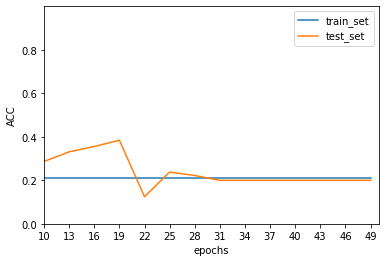

In [38]:
# Accuracy vs Epochs. Adam solver.
data=pd.DataFrame()
data['train_acc']=train_acc
data['test_acc']=test_acc
plt.xlim((10, 50))
plt.ylim((0, 1))
plt.xlabel('epochs')
plt.ylabel('ACC')
my_x_ticks = np.arange(10, 50, 3)
my_y_ticks = np.arange(0, 1, 0.2)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.plot(list(range(10,50,3)),data['train_acc'],label="train_set")
plt.plot(list(range(10,50,3)),data['test_acc'],label="test_set")
plt.legend()
plt.show()

In [39]:
train_acc=[]
test_acc=[]
for learning_rate in [0.05,0.1,0.2,0.5,1]:
    mlp = MLPClassifier(solver='adam', activation='relu',alpha=1e-4,hidden_layer_sizes=(50,50), random_state=1,max_iter=epochs,verbose=10,learning_rate_init=learning_rate)
    mlp.fit(train_new_fea_std,train_label)
    pre_valid_label=mlp.predict(valid_new_fea_std)
    pre_train_label=mlp.predict(train_new_fea_std)
    train_acc.append(accuracy_score(pre_train_label,train_label))
    test_acc.append(accuracy_score(pre_valid_label,valid_label))

Iteration 1, loss = 1.70163185
Iteration 2, loss = 1.11178247
Iteration 3, loss = 1.01311231
Iteration 4, loss = 1.00011199
Iteration 5, loss = 0.93884755
Iteration 6, loss = 0.86690764
Iteration 7, loss = 0.86532991
Iteration 8, loss = 0.88435029
Iteration 9, loss = 0.82695786
Iteration 10, loss = 0.84387443
Iteration 11, loss = 0.83092643
Iteration 12, loss = 0.83089103
Iteration 13, loss = 0.90995982
Iteration 14, loss = 0.87586172
Iteration 15, loss = 0.81568677
Iteration 16, loss = 0.76336152
Iteration 17, loss = 0.79262461
Iteration 18, loss = 0.82767014
Iteration 19, loss = 0.82361257
Iteration 20, loss = 0.77243834
Iteration 21, loss = 0.75741401
Iteration 22, loss = 0.75060830
Iteration 23, loss = 0.76486853
Iteration 24, loss = 0.76129290
Iteration 25, loss = 0.74535226
Iteration 26, loss = 0.72250386
Iteration 27, loss = 0.76054971
Iteration 28, loss = 0.75536339
Iteration 29, loss = 0.96593544
Iteration 30, loss = 0.92112901
Iteration 31, loss = 0.85352931
Iteration 32, los

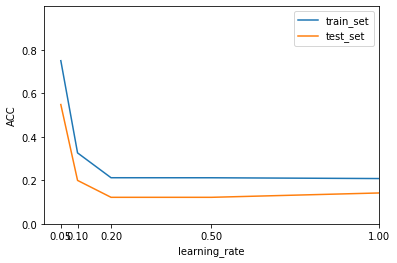

In [40]:
# Accuracy vs learning rate. Adam solver.
data=pd.DataFrame()
data['train_acc']=train_acc
data['test_acc']=test_acc
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.xlabel('learning_rate')
plt.ylabel('ACC')
my_x_ticks = [0.05,0.1,0.2,0.5,1]
my_y_ticks = np.arange(0, 1, 0.2)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.plot(my_x_ticks,data['train_acc'],label="train_set")
plt.plot(my_x_ticks,data['test_acc'],label="test_set")
plt.legend()
plt.show()

In [41]:
# export testing result
res=pd.DataFrame()
res['trackID']=test_Id
res['genre']=test_pre_label
res['genre']=res['genre'].map(label_back)
res.to_csv('mlp.csv',index=False)

##### LGBM Model

In [42]:
# LGBM model
lgb_model=lgb.LGBMClassifier(boosting_type='gbdt',objective='multiclass',learning_rate=0.05,num_leaves=10)

In [43]:
lgb_model.fit(train_new_fea_std,train_label)
pre_valid_label=lgb_model.predict(valid_new_fea_std)
accuracy_score(pre_valid_label,valid_label)
test_pre_label=lgb_model.predict(test_new_fea_std)
print("the acc of lgb is:")
accuracy_score(pre_valid_label,valid_label)

the acc of lgb is:


0.6444444444444445

In [44]:
# classification report
print(lgb_model)
print(classification_report(pre_valid_label,valid_label))
print("Note: 0:'metal',1:'folk',2:'jazz and blues',3:'soul and reggae',4:'classic pop and rock',5:'punk',6:'dance and electronica',7:'pop'")

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=10, objective='multiclass',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
              precision    recall  f1-score   support

           0       0.64      0.89      0.74        47
           1       0.73      0.46      0.57       102
           2       0.25      0.92      0.39        12
           3       0.76      0.71      0.73        62
           4       0.64      0.47      0.54        74
           5       0.77      0.51      0.61        67
           6       0.24      0.73      0.37        15
           7       0.89      0.93      0.91        71

   micro avg       0.64      0.64      0.64       450
   macro avg       0.62  

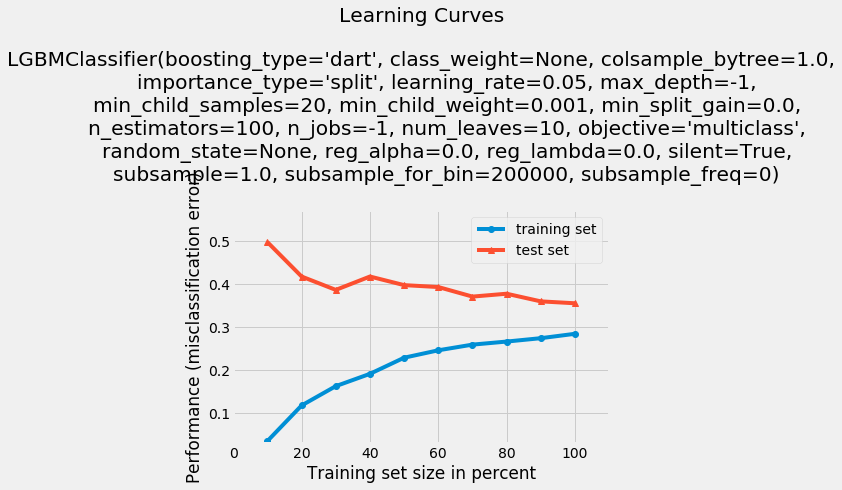

In [45]:
# learning curve of LGBM model
lgb_model=lgb.LGBMClassifier(boosting_type='dart',objective='multiclass',learning_rate=0.05,num_leaves=10)
plot_learning_curves(train_new_fea_std, train_label, valid_new_fea_std, valid_label, lgb_model)
plt.show()

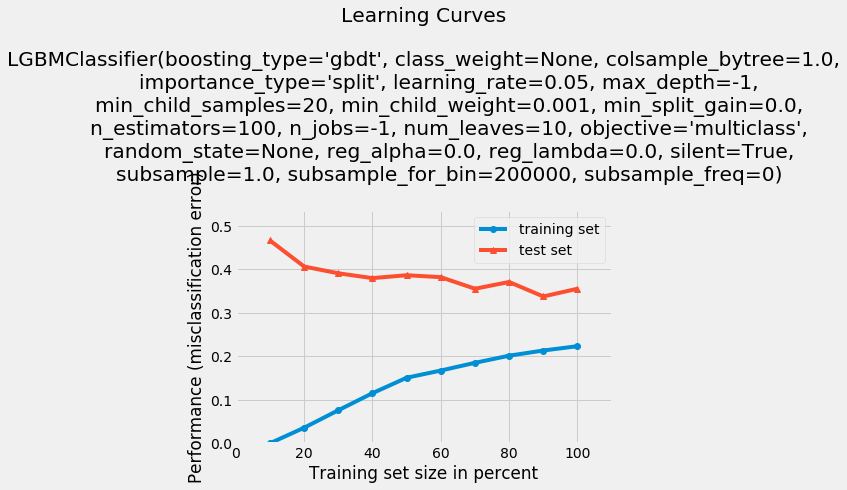

In [46]:
# learning curve of re-tuned LGBM model
lgb_model=lgb.LGBMClassifier(boosting_type='gbdt',objective='multiclass',learning_rate=0.05,num_leaves=10)
plot_learning_curves(train_new_fea_std, train_label, valid_new_fea_std, valid_label, lgb_model)
plt.show()

In [47]:
# Accuracy vs num_leaves
train_acc=[]
test_acc=[]
for num in [5,10,15,20,25,30,40,50]:
    lgb_model=lgb.LGBMClassifier(boosting_type='gbdt',objective='multiclass',learning_rate=0.05,num_leaves=num)
    lgb_model.fit(train_new_fea_std,train_label)
    pre_valid_label=lgb_model.predict(valid_new_fea_std)
    pre_train_label=lgb_model.predict(train_new_fea_std)
    train_acc.append(accuracy_score(pre_train_label,train_label))
    test_acc.append(accuracy_score(pre_valid_label,valid_label))

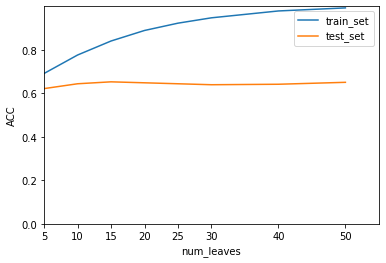

In [48]:
data=pd.DataFrame()
data['train_acc']=train_acc
data['test_acc']=test_acc
plt.xlim((5, 55))
plt.ylim((0, 1))
plt.xlabel('num_leaves')
plt.ylabel('ACC')
my_x_ticks = [5,10,15,20,25,30,40,50]
my_y_ticks = np.arange(0, 1, 0.2)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.plot(my_x_ticks,data['train_acc'],label="train_set")
plt.plot(my_x_ticks,data['test_acc'],label="test_set")
plt.legend()
plt.show()

In [49]:
# Accuracy of gbdt vs dart type.
train_acc=[]
test_acc=[]
for boostingType in ['gbdt','dart']:
    lgb_model=lgb.LGBMClassifier(boosting_type=boostingType,objective='multiclass',learning_rate=0.05,num_leaves=20)
    lgb_model.fit(train_new_fea_std,train_label)
    pre_valid_label=lgb_model.predict(valid_new_fea_std)
    pre_train_label=lgb_model.predict(train_new_fea_std)
    train_acc.append(accuracy_score(pre_train_label,train_label))
    test_acc.append(accuracy_score(pre_valid_label,valid_label))

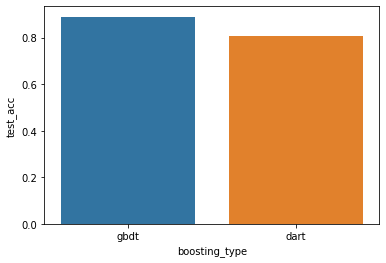

In [50]:
data=pd.DataFrame()
data['boosting_type']=['gbdt','dart']
data['train_acc']=list(train_acc)
data['test_acc']=list(train_acc)
sns.barplot(x="boosting_type", y="test_acc", data=data)

In [51]:
# export testing result
res=pd.DataFrame()
res['trackID']=test_Id
res['genre']=test_pre_label
res['genre']=res['genre'].map(label_back)
res.to_csv('lgb.csv',index=False)

##### Baseline Model

In [52]:
#baseline model
from  sklearn.dummy import DummyClassifier
train_acc=[]
test_acc=[]
for Strategy in ['stratified','uniform','most_frequent']:
    dummy_clf=DummyClassifier(strategy=Strategy)
    dummy_clf.fit(train_new_fea_std,train_label)
    pre_valid_label=dummy_clf.predict(valid_new_fea_std)
    pre_train_label=dummy_clf.predict(train_new_fea_std)
    train_acc.append(accuracy_score(pre_train_label,train_label))
    test_acc.append(accuracy_score(pre_valid_label,valid_label))

print(test_acc)

[0.11333333333333333, 0.12222222222222222, 0.12222222222222222]


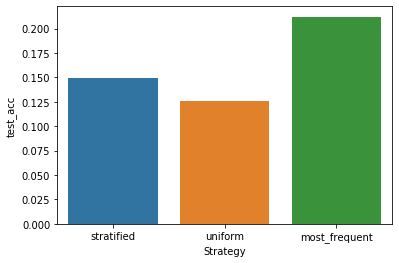

In [53]:
# Accuracy of different strategy
data=pd.DataFrame()
data['Strategy']=['stratified','uniform','most_frequent']
data['train_acc']=list(train_acc)
data['test_acc']=list(train_acc)
sns.barplot(x="Strategy", y="test_acc", data=data)